# RNN Implementation

In [ ]:
import pandas as pd
import torch
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
from keras import regularizers
import kerastuner as kt
from metrics_plot_utils import *

In [1]:
import os
import sys

original_sys_path = sys.path.copy()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../general_utils'))
sys.path.append(parent_dir)

from preprocessing import *
from nn_utils import *
sys.path = original_sys_path

[nltk_data] Downloading package punkt_tab to /Users/sara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Yangswei_85

To use the Yangswei_85 dataset, run the cell below.

In [30]:
# Load training set
df_train = pd.read_csv('data/train_yangswei_85.csv')  
# Load test set
test_df = pd.read_csv('data/test_yangswei_85.csv')
dataset_name = 'Yangswei_85'

# T5 
To use the T5 dataset, run the cell below.

In [5]:
# Load training set
df_train = pd.read_csv('data/train_t5.csv')  
# Load test set
test_df = pd.read_csv('data/test_t5.csv')
dataset_name = 'T5'

# Training and Validation

## Training Data Preprocessing

Firstly, we apply preprocessing (fixing contractions, setting all text to lowercase, removing non-alphanumeric characters) to the training text.

Secondly, we tokenize and pad the training text using Keras' Tokenize, introducing a <UNK> token for unknown entries of the vocabulary.

Lastly, we encode the labels of the training dataset and save them to a npy file called 'label_classes.npy'.

In [ ]:
#Preprocess training data
df_train['text'].apply(preprocess).to_frame()


# Tokenize and pad training data
padded_sequences, tokenizer, vocab_size = tokenize_and_pad(df_train[['text']])

# Set training data
padded_train_data = padded_sequences

#Encode labels and save classes in npy file
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])
np.save('data/label_classes.npy', label_encoder.classes_)
train_labels = torch.tensor(label_encoder.transform(df_train['label']),dtype=torch.long)
num_classes = len(label_encoder.classes_)
train_labels_one_hot_encoded = tf.keras.utils.to_categorical(train_labels)

shape 
(30000, 2)
max  sequences length 116
pad sequences shape 30000


## Tune Hyperparameters

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [64, 128])))

    # Adjustable number of RNN layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
    for i in range(num_layers):
        units = hp.Int(f'rnn_units_{i}', min_value=32, max_value=128, step=32)
        model.add(SimpleRNN(units, return_sequences=(i < num_layers - 1), kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  
    executions_per_trial=2
)

tuner.search(padded_train_data, train_labels_one_hot_encoded, epochs=7, validation_split=0.2, batch_size=64)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

Trial 10 Complete [00h 04m 56s]
val_accuracy: 0.593500018119812

Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 51m 12s
Best hyperparameters: {'output_dim': 64, 'num_layers': 1, 'rnn_units_0': 32, 'dropout_rate_0': 0.4, 'rnn_units_1': 64, 'dropout_rate_1': 0.2}


Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 51m 12s
For max_trials = 10
Best hyperparameters: {'output_dim': 64, 'num_layers': 1, 'rnn_units_0': 32, 'dropout_rate_0': 0.4, 'rnn_units_1': 64, 'dropout_rate_1': 0.2}

## Train and Validate best model

Start Training and Validation:

Epoch 1/20
375/375 [==============================] - ETA: 0s - loss: 1.2530 - accuracy: 0.5810
Epoch 1: val_loss improved from inf to 1.17507, saving model to models/best_rnn_model.h5
375/375 [==============================] - 7s 18ms/step - loss: 1.2530 - accuracy: 0.5810 - val_loss: 1.1751 - val_accuracy: 0.5935
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 1.1834 - accuracy: 0.5947
Epoch 2: val_loss improved from 1.17507 to 1.15552, saving model to models/best_rnn_model.h5
375/375 [==============================] - 7s 19ms/step - loss: 1.1834 - accuracy: 0.5947 - val_loss: 1.1555 - val_accuracy: 0.5937
Epoch 3/20
372/375 [============================>.] - ETA: 0s - loss: 1.1500 - accuracy: 0.5971
Epoch 3: val_loss did not improve from 1.15552
375/375 [==============================] - 7s 18ms/step - loss: 1.1494 - accuracy: 0.5974 - val_loss: 1.1659 - val_accuracy: 0.5932
Epoch 4/20
375/375 [==============================] - E

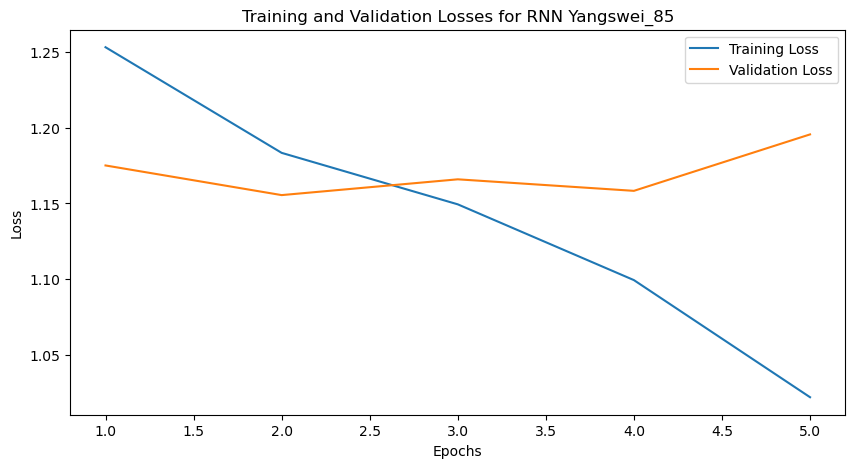

In [ ]:
print("Start Training and Validation:\n")
epochs = 50
patience = 15
batch_size = 64


rnn_model = build_model(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_rnn_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = rnn_model.fit(
    padded_train_data, 
    train_labels_one_hot_encoded, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[early_stopping, model_checkpoint], 
    verbose=1
)
# Extract training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']
actual_epochs =  len(train_losses)
# Plot training and validation losses
plot_losses("RNN", dataset_name, train_losses, val_losses, actual_epochs)


# Test

## Test Data Preprocessing

In [17]:
# Preprocess test data
test_df['text'].apply(preprocess).to_frame()  

# Tokenize and pad test data using the same tokenizer from training
padded_test_sequences = tokenizer.texts_to_sequences(test_df['text'])
padded_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(padded_test_sequences, maxlen=padded_train_data.shape[1])

# Tokenize and pad test data
padded_sequences, _, _ = tokenize_and_pad(test_df[['text']])

# Set test data
test_data = padded_sequences

#Encode test labels by loading encoder used for training labels
true_labels = test_df['label']
label_classes = np.load('data/label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
test_labels = torch.tensor(label_encoder.transform(true_labels))
test_labels_one_hot_encoded = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

max  sequences length 113
pad sequences shape 22289


## Test best model on test data

In [22]:

# Load the saved model
model = tf.keras.models.load_model('models/best_rnn_model.h5')


test_loss, test_accuracy = model.evaluate(padded_test_sequences, test_labels_one_hot_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


predictions_probabilities = model.predict(padded_test_sequences)
predicted_classes = label_encoder.inverse_transform(np.argmax(predictions_probabilities, axis=1))
true_classes = label_encoder.inverse_transform(np.argmax(test_labels_one_hot_encoded, axis=1))

697/697 [==============================] - 2s 3ms/step - loss: 1.1861 - accuracy: 0.5965
Test Loss: 1.1861, Test Accuracy: 0.5965
697/697 [==============================] - 2s 3ms/step


## Compute metrics on model performance

/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.5965


Macro Metrics
Macro Precision: 0.1425
Macro Recall: 0.1673
Macro F1 Score: 0.1281


Weighted Metrics
Weighted Precision: 0.4050
Weighted Recall: 0.5965
Weighted F1 Score: 0.4515


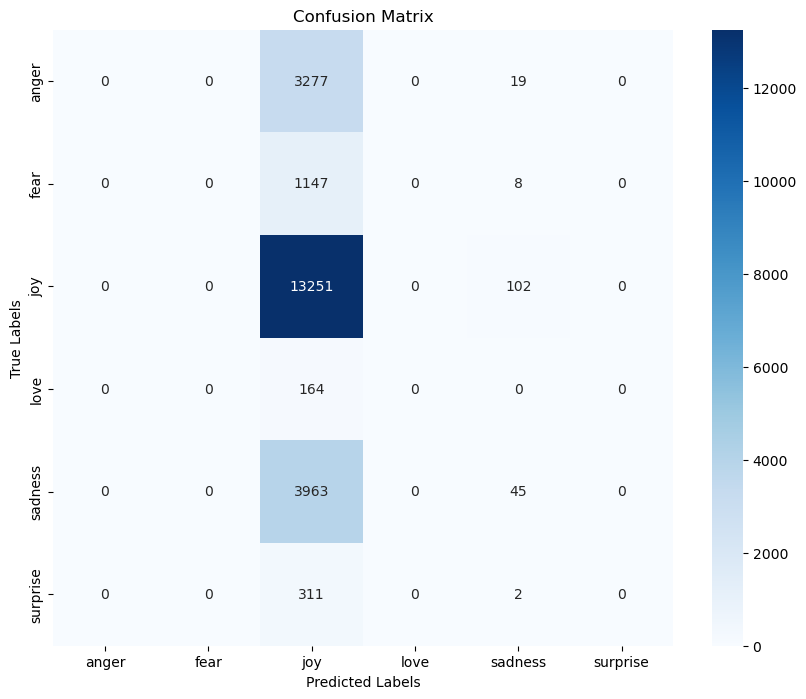

In [26]:

# Compute metrics
metrics = compute_metrics(predicted_classes, true_classes)
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print('\n')
print('Macro Metrics')
print(f"Macro Precision: {metrics['precision']:.4f}")
print(f"Macro Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1']:.4f}")
print('\n')
print('Weighted Metrics')
print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
print(f"Weighted F1 Score: {metrics['f1_weighted']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, label_classes)

In [28]:

# Print classification report
print('Classification Report:\n')
print(classification_report(true_classes, predicted_classes, target_names=label_classes))


Classification Report:



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3296
        fear       0.00      0.00      0.00      1155
         joy       0.60      0.99      0.75     13353
        love       0.00      0.00      0.00       164
     sadness       0.26      0.01      0.02      4008
    surprise       0.00      0.00      0.00       313

    accuracy                           0.60     22289
   macro avg       0.14      0.17      0.13     22289
weighted avg       0.40      0.60      0.45     22289



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
